In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import sinetym.datasets
import sinetym.models
import sinetym.auxiliary
import sinetym.phonology
import sinetym.plot

import sys
import json
sys.path.append(r'C:\Users\lerna\git\sinetym\scripts')
import encoder

np.random.seed(5981)

In [2]:
config = json.load(open(r'C:\Users\lerna\git\sinetym\scripts\benchmark.json'))
prefix = config['output_dir']
model_name = 'linear_encoder_100_100_100_1_1_0.00005_sgd_exponential_decay_0.1_10000_0.95_0.6_100'

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


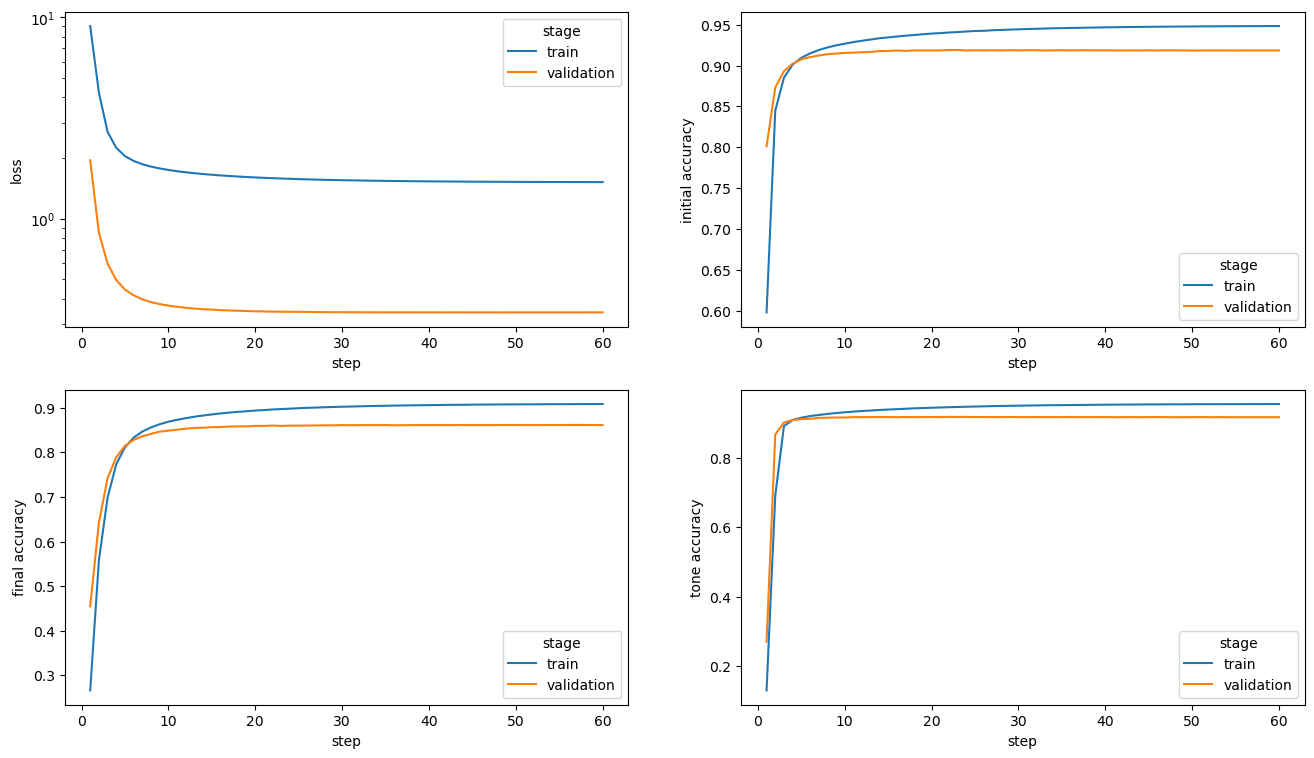

In [3]:
values = []
for stage in ('train', 'validate'):
    for e in os.scandir(os.path.join(prefix, model_name, stage)):
        if e.is_file():
            for event in tf.compat.v1.train.summary_iterator(e.path):
                for v in event.summary.value:
                    if v.metadata.plugin_data.plugin_name == 'scalars':
                        values.append((stage, v.tag, event.step, event.wall_time, float(tf.make_ndarray(v.tensor))))

stats = pd.DataFrame(values, columns=['stage', 'name', 'step', 'wall_time', 'value'])
stats['name'] = stats['name'].map({'loss': 'loss', 'accuracy0': 'initial', 'accuracy1': 'final', 'accuracy2': 'tone'})

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(2, 2, 1)
sns.lineplot(data=stats[stats['name'] == 'loss'], x='step', y='value', hue='stage', ax=ax)
ax.set_yscale('log')
ax.set_ylabel('loss')

for i, name in enumerate(('initial', 'final', 'tone')):
    ax = fig.add_subplot(2, 2, i + 2)
    sns.lineplot(data=stats[stats['name'] == name], x='step', y='value', hue='stage', ax=ax)
    ax.set_ylabel(f'{name} accuracy')

plt.show()
plt.close()

In [5]:
dialect_columns, input_columns, output_columns = [config['columns'][n] for n in ('dialect', 'input', 'output')]

dict_dir = config.get('dictionary_dir', os.path.join(prefix, 'dictionaries'))
dicts = encoder.load_dictionaries(dict_dir)

for name in config['columns']:
    globals()[f'{name}_encoder'] = OrdinalEncoder(
        categories=[dicts[n].index for n in config['columns'][name]],
        dtype=np.int32,
        handle_unknown='use_encoded_value',
        unknown_value=-1,
        encoded_missing_value=-1
    ).fit([[''] * len(config['columns'][name])])

conf = [c for c in config['models'] if c['name'] == model_name][0].copy()
conf.pop('name')
model, _ = encoder.build_model(
    conf,
    **dict([(f'{name}_nums', [len(dicts[n]) for n in config['columns'][name]]) \
        for name in ('dialect', 'input', 'output')])
)
checkpoint = tf.train.Checkpoint(model=model)
manager = tf.train.CheckpointManager(checkpoint, os.path.join(prefix, model_name, 'checkpoints'), None)
manager.restore_or_initialize()

for name in ('dialect', 'input', 'output'):
    globals()[f'{name}_embs'] = [e.numpy() for e in getattr(model, f'{name}_embs')]
    for i, n in enumerate(config['columns'][name]):
        globals()[f'{n}_emb'] = globals()[f'{name}_embs'][i]

    if hasattr(model, f'{name}_biases'):
        globals()[f'{name}_biases'] = [e.numpy() for e in getattr(model, f'{name}_biases')]
        for i, n in enumerate(config['columns'][name]):
            globals()[f'{n}_bias'] = globals()[f'{name}_biases'][i]

weight = model.weight.numpy()

In [6]:
new_dict_dir = os.path.join(dict_dir, 'new_dialect')
new_dicts = encoder.load_dictionaries(new_dict_dir)

new_model = encoder.build_new_model(model, dialect_nums=[new_dicts['did'].shape[0]])
checkpoint = tf.train.Checkpoint(model=new_model)
manager = tf.train.CheckpointManager(
    checkpoint,
    os.path.join(prefix, model_name, 'new_dialect', 'checkpoints'),
    None
)
manager.restore_or_initialize()

'Y:\\data\\models\\benchmark\\linear_encoder_100_100_100_1_1_0.00005_sgd_exponential_decay_0.1_10000_0.95_0.6_100\\new_dialect\\checkpoints\\ckpt-10'

In [7]:
dialect_infos = []
for d in config['datasets']:
    d = getattr(sinetym.datasets, d if isinstance(d, str) else d['name'])
    info = d.metadata['dialect_info'][[
        'group',
        'subgroup',
        'cluster',
        'subcluster',
        'spot',
        'latitude',
        'longitude'
    ]].copy()
    info.insert(0, 'dataset', d.name)
    info['did'] = info.index + 'mb01' if d is sinetym.datasets.zhongguoyuyan else info.index
    dialect_infos.append(info)

dialect = pd.concat(dialect_infos, axis=0)
dialect['idx'] = dialect_encoder.transform(dialect[dialect_columns])[:, 0]
dialect['new'] = dialect['idx'] < 0

c:\Users\lerna\AppData\Local\miniconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


In [8]:
char = sinetym.datasets.zhongguoyuyan.metadata['char_info'].copy()
char['cid'] = char.index
char['idx'] = input_encoder.transform(char[input_columns])[:, 0]
char['new'] = char['idx'] < 0

char[['initial_type', 'tone']] = sinetym.datasets.zhongguoyuyan.filter(id='08210mb01') \
    .groupby('cid').agg({
        'initial': lambda x: x.map(sinetym.phonology.get_voicing).fillna('').mode().iloc[0],
        'tone': lambda x: x.mode().iloc[0]
    })
char[['initial_manner', 'coda_type']] = sinetym.datasets.zhongguoyuyan.filter(id='15233mb01') \
    .groupby('cid').agg({
        'initial': lambda x: x.map(sinetym.phonology.get_manner).fillna('').mode().iloc[0],
        'final': lambda x: x.map(sinetym.phonology.get_coda_type).fillna('').mode().iloc[0]
    })

c:\Users\lerna\AppData\Local\miniconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


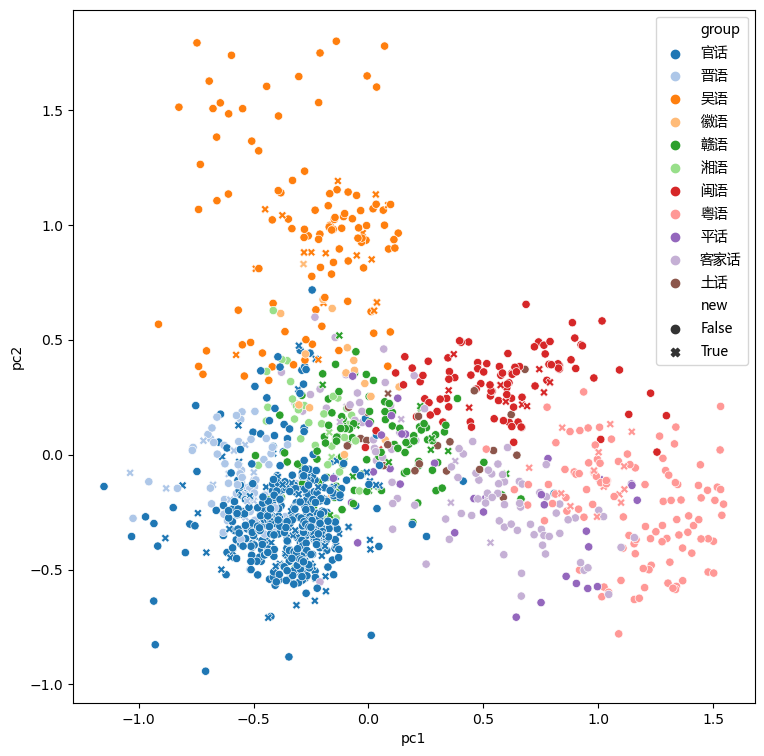

In [9]:
dialect_emb = did_emb[dialect['idx']]
idx = OrdinalEncoder(
    categories=[new_dicts['did'].index],
    dtype=np.int32,
    handle_unknown='use_encoded_value',
    unknown_value=-1,
    encoded_missing_value=-1
).fit_transform(dialect.loc[dialect['new'], dialect_columns])[:, 0]
dialect_emb[dialect['new']] = new_model.dialect_embs[0].numpy()[idx]
dialect[['pc1', 'pc2']] = PCA(2).fit_transform(dialect_emb)

fig = plt.figure(figsize=(16, 9))
ax = plt.axes(aspect='equal')
sns.scatterplot(dialect[dialect['group'] != ''], x='pc1', y='pc2', hue='group', style='new', palette='tab20', ax=ax)
ax.legend(prop={'family': 'Microsoft Yahei'})
plt.show()
plt.close()

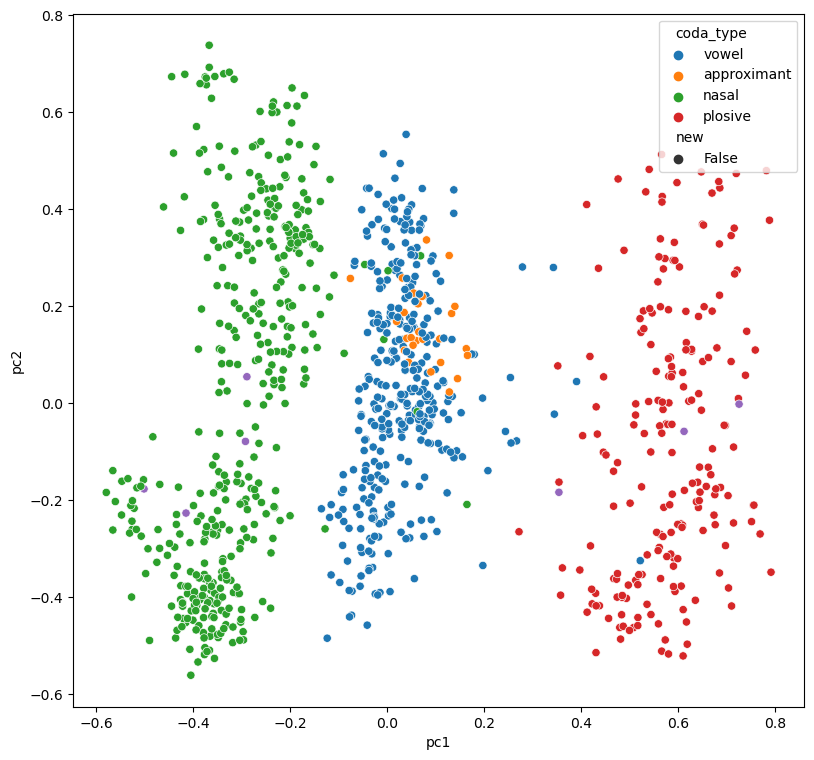

In [10]:
char_emb = cid_emb[char['idx']]

if char['new'].any():
    idx = OrdinalEncoder(
        categories=[new_cid],
        dtype=np.int32,
        handle_unknown='use_encoded_value',
        unknown_value=-1,
        encoded_missing_value=-1
    ).fit_transform(char.loc[char['new'], input_columns])[:, 0]
    cha_emb[char['new']] = new_model.input_embs[0].numpy()[idx]

char[['pc1', 'pc2']] = PCA(2).fit_transform(char_emb)

plt.figure(figsize=(16, 9))
ax = plt.axes(aspect='equal')
sns.scatterplot(char, x='pc1', y='pc2', hue='coda_type', style='new', palette='tab10', ax=ax)
plt.show()
plt.close()